## Autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## Libraries

In [2]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import detrend, butter, filtfilt
import ipywidgets as widgets
from IPython.display import display
from signalepy import utils, fourier, wavelet, ssi_cov
import numpy as np
import matplotlib.pyplot as plt 
import json
import os

## Parameters

### Accceleration data

In [3]:
# Column names of the data
labels = ["X", "Y", "Z"] # + Acceleration
labels_corrected = ["X Corrected", "Y Corrected", "Z Corrected"] # + Acceleration
label = labels[2]
labels_filtered = ["X Filtered", "Y Filtered", "Z Filtered"] # + Acceleration
label_filtered = labels_filtered[2]

# Butterworth filter parameters
lowcut = 0.3  # Lower cutoff frequency (Hz)
highcut = 30  # Upper cutoff frequency (Hz)
order = 3  # Filter order

# FFT filtering
threshold = 20  # Threshold for filtering the FFT, as percentage of the maximum value

# time window for the data
start_time = 0
power_of_two = 10

# FFT normalization
magnitude_type = 'calculated'  # 'normalized' or 'calculated'
magnitude_factor = 10  # Factor for the magnitude normalization

# Files
file_name = 'cable_acceleration.txt'
file_location = utils.get_tests_files_location(file_name)

# Wavelet parameters
wavelet_function ='morl'

# SSI-COV parameters
min_model_order = 3
max_model_order = 30

In [4]:
# Definir las entradas de frecuencia y amplitud para cada dirección
frequency_inputs = {
    'X': [10, lambda t: 35 + 0.05 * np.sin(2 * np.pi + 0.1 * t)],
    'Y': [15, lambda t: 30 + 0.05 * np.sin(2 * np.pi + 0.2 * t)],
    'Z': [20, lambda t: 25 + 0.05 * np.sin(2 * np.pi +  0.3 * t)]
}

amplitude_inputs = {
    'X': [1, lambda t: 1 + 0.5 * np.sin(2 * np.pi - 0.1 * t)],
    'Y': [0.8, lambda t: 0.8 + 0.3 * np.sin(2 * np.pi - 0.2 * t)],
    'Z': [0.6, lambda t: 0.6 + 0.2 * np.sin(2 * np.pi - 0.3 * t)]
}

# Definir las amplitudes de ruido para cada dirección
noise_amplitudes = {
    'X': 0.10,
    'Y': 0.05,
    'Z': 0.15
}

# Definir las etiquetas de las direcciones
labels = ['X', 'Y', 'Z']

# Generar las señales de vibración
total_time = 25  # Duración total de la señal en segundos
sampling_rate = 100.0  # Tasa de muestreo en Hz

In [5]:
df_original = utils.generate_vibration_signals(
    labels=labels,
    total_time=total_time,
    sampling_rate=sampling_rate,
    frequency_inputs=frequency_inputs,
    amplitude_inputs=amplitude_inputs,
    noise_amplitudes=noise_amplitudes,
)
    

In [6]:
utils.plotly_acceleration(df_original, label, color='black')

In [7]:
df_ready = utils.SignalProcessor(df_original, labels, lowcut, highcut, order, start_time, power_of_two).execute_preparing_signal()

In [8]:
n = utils.estimate_power_of_two(df_original) # maximun exponent for the number of samples recomended for the fft
print(f'n = {n}')

n = 12


In [9]:
utils.plotly_acceleration(df_ready, labels[0], color='black') # 0 for 'X', 1 for 'Y', 2 for 'Z'

## FFT analysis

In [10]:
df_fft = fourier.calculate_fft(df_ready, labels)

In [11]:
fourier.plotly_fft_results(df_fft, label, 'black')

## Denoising

In [12]:
df_filtered = fourier.filter_with_fft(df=df_ready, labels=labels, threshold=threshold)

In [13]:
df_fft_filtered = fourier.calculate_fft(df_filtered, labels_filtered, magnitude_type, magnitude_factor)

In [14]:
fourier.plotly_fft_results(df_fft_filtered, label_filtered, 'black')

In [15]:
fourier.plotly_normalized_fft_results(df_fft_filtered, label_filtered,'black')

In [16]:
utils.plotly_acceleration(df_ready, label)

In [17]:
fourier.plotly_peaks(df_fft_filtered, label_filtered, log_scale=True)

In [18]:
fourier.plotly_fft_results_period_domain(df_fft_filtered, label_filtered, color='blue', log_scale=True)

## SSICOV

In [19]:
ssicov = ssi_cov.SSICov(df_filtered, labels, min_model_order, max_model_order)

In [20]:
ssicov.plotly_stability_diagram()

Processing status 5/5: 100%|██████████| 27/27 [00:00<00:00, 26912.12it/s]


## Wavelets

In [21]:
spectrum, frequencies = wavelet.calculate_cwt(df_filtered, label_filtered, wavelet_function, lowcut, highcut)

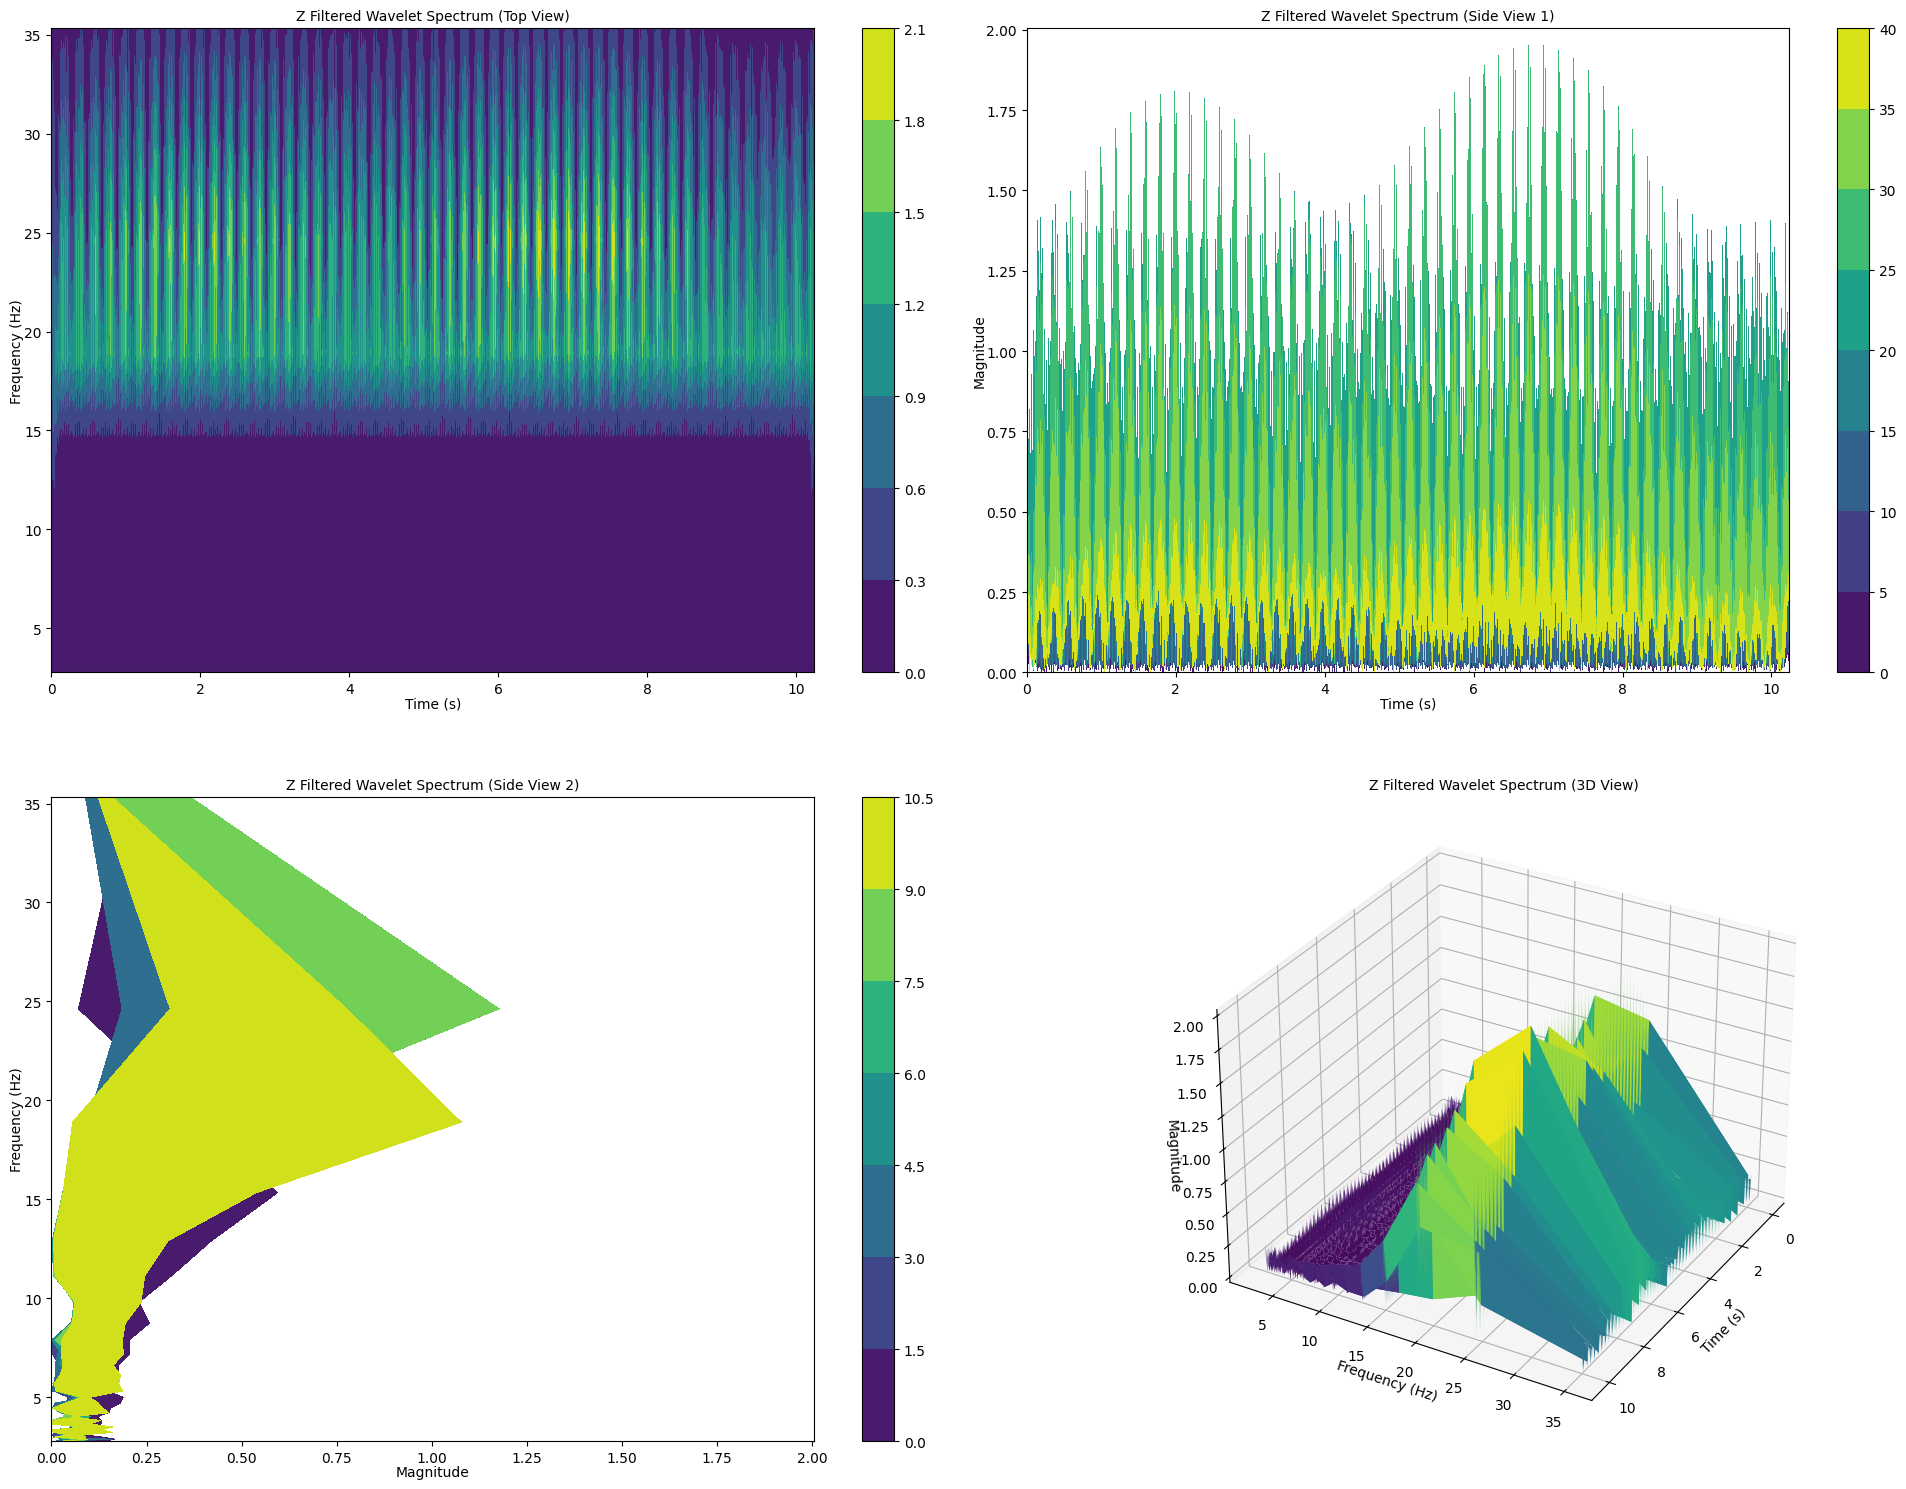

In [22]:
wavelet.plot_spectrum_views(df_ready, spectrum, frequencies, label_filtered)